In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import math
from sklearn import metrics
from random import randint
from matplotlib import style
import itertools

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler


from IPython.display import display

import acquire as aq
import env

# Exercise

## Clustering - DBSCAN

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

### Acquire

In [2]:
url = env.get_db_url('grocery_db')
query = 'SELECT * FROM grocery_customers'
df = pd.read_sql(query, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


### Prepare

In [3]:
# Make all columns lowercase
for col in df.columns:
    df = df.rename(columns={col: col.lower()})

In [4]:
# Rename the delicassen columns
df = df.rename(columns={'delicassen': 'deli'})
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   channel           440 non-null    int64
 1   region            440 non-null    int64
 2   fresh             440 non-null    int64
 3   milk              440 non-null    int64
 4   grocery           440 non-null    int64
 5   frozen            440 non-null    int64
 6   detergents_paper  440 non-null    int64
 7   deli              440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [6]:
df.describe()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Scaling

In [7]:
# Create a subset of features

subset = df[["grocery", "milk", "fresh", "frozen", "deli"]]
subset.head()

,grocery,milk,fresh,frozen,deli
customer_id,,,,,
0,7561,9656,12669,214,1338
1,9568,9810,7057,1762,1776
2,7684,8808,6353,2405,7844
3,4221,1196,13265,6404,1788
4,7198,5410,22615,3915,5185


In [8]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(subset)

# Use the scaler
subset = scaler.transform(subset)
subset

array([[0.08146416, 0.13072723, 0.11294004, 0.0031063 , 0.02784731],
       [0.10309667, 0.13282409, 0.06289903, 0.02854842, 0.03698373],
       [0.08278992, 0.11918086, 0.05662161, 0.03911643, 0.16355861],
       ...,
       [0.32594285, 0.21013575, 0.1295431 , 0.00677142, 0.03888194],
       [0.02402535, 0.02622442, 0.091727  , 0.01664914, 0.04426366],
       [0.02702178, 0.02237109, 0.02482434, 0.00065742, 0.00102211]])

### DB Scan

In [9]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(subset)

DBSCAN(eps=0.1, min_samples=20)

In [10]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["grocery", "milk", "fresh", "frozen", "deli"]
scaled_columns = ["scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(subset, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_grocery,scaled_milk,scaled_fresh,scaled_frozen,scaled_deli
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0.003106,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0.028548,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0.039116,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0.104842,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0.063934,0.108093


In [11]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    391
-1     49
Name: labels, dtype: int64

In [12]:
df.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_grocery,scaled_milk,scaled_fresh,scaled_frozen,scaled_deli,labels
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0.003106,0.027847,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0.028548,0.036984,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0.039116,0.163559,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0.104842,0.037234,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0.063934,0.108093,0


Text(0.5, 0, 'Grocery')

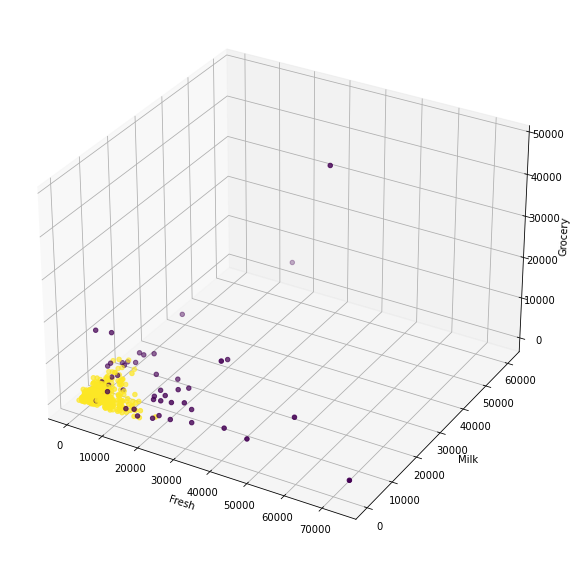

In [13]:
# Now let's plot the results

fig = plt.figure(figsize = (8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1])

ax.scatter(df.milk, df.frozen, df.deli, c = df.labels)

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

### Acquire

In [14]:
# Use predefined function to acquire 
df = aq.acquire_logs()
df.head()

Using cached .csv file...


,Unnamed: 0,date,time,path,user_id,cohort_id,ip
0,0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  900223 non-null  int64  
 1   date        900223 non-null  object 
 2   time        900223 non-null  object 
 3   path        900222 non-null  object 
 4   user_id     900223 non-null  int64  
 5   cohort_id   847330 non-null  float64
 6   ip          900223 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 48.1+ MB


### Prepare

In [16]:
# Aggregate the data 
id_counts = df.groupby('user_id')[['date','path','cohort_id']].nunique()
id_counts

,date,path,cohort_id
user_id,,,
1,637,976,2
2,83,151,1
3,107,169,1
4,54,143,1
5,82,197,1
...,...,...,...
977,10,12,1
978,9,18,1
979,9,20,1


### Scaling

In [17]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(id_counts), columns = id_counts.columns)
scaled.head()

,date,path,cohort_id
0,0.768116,1.000000,0.666667
1,0.099034,0.153846,0.333333
2,0.128019,0.172308,0.333333
3,0.064010,0.145641,0.333333
4,0.097826,0.201026,0.333333


### DB Scan

In [18]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(scaled)

DBSCAN(eps=0.1, min_samples=20)

In [19]:
# Assign the labels created by DBSCAN to id_counts
id_counts['labels'] = dbsc.labels_

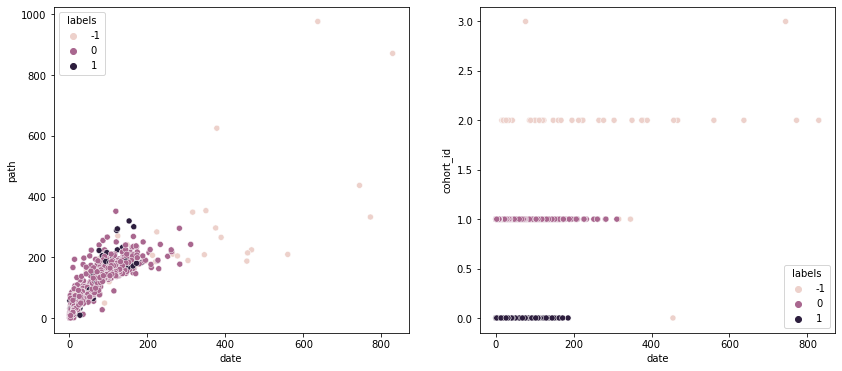

In [20]:
# Visualize the anomalies

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (14, 6))

sns.scatterplot(data = id_counts, x = 'date', y = 'path', hue = 'labels', ax = ax[0])
sns.scatterplot(data = id_counts, x = 'date', y = 'cohort_id', hue = 'labels', ax = ax[1]);

**The -1 labeled data points look to be the most anomalous.**

In [21]:
## Let's see which rows make up this label
id_counts[id_counts.labels == -1]

,date,path,cohort_id,labels
user_id,,,,
1,637,976,2,-1
11,829,871,2,-1
25,114,154,2,-1
37,43,156,2,-1
40,102,120,2,-1
41,221,186,2,-1
53,772,333,2,-1
64,744,437,3,-1
88,77,197,3,-1


### 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

### Acquire and Prepare

In [39]:
df = aq.prepare_zillow(aq.acquire())
df.head()

Using cached csv...


,bathrooms,bedrooms,building_quality,home_sqft,fips,latitude,longitude,lot_sqft,regionidcity,regionidcounty,...,structure_tax_value,assessed_value,land_tax_value,tax_amount,censustractandblock,logerror,heating_system,land_use,county,age
1,1.0,2.0,6.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,2061.0,...,88000.0,464000.0,376000.0,5672.48,61110010023006.0,0.055619,None,Single Family Residential,Ventura,49.0
2,2.0,3.0,6.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,1286.0,...,85289.0,564778.0,479489.0,6488.30,60590218022012.0,0.005383,None,Single Family Residential,Orange,54.0
3,3.0,4.0,8.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,3101.0,...,108918.0,145143.0,36225.0,1777.51,60373001001006.0,-0.103410,Central,Single Family Residential,Los Angeles,46.0
4,3.0,3.0,8.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,12447.0,3101.0,...,73681.0,119407.0,45726.0,1533.89,60371236012000.0,0.006940,Central,Condominium,Los Angeles,52.0
5,2.0,3.0,6.0,1492.0,6111.0,34230044.0,-118993991.0,903.0,51239.0,2061.0,...,198640.0,331064.0,132424.0,3508.10,61110053062009.0,-0.020526,None,Condominium,Ventura,34.0


## Scaling

In [51]:
# Create a subset of features

subset = df[["bedrooms", "bathrooms"]]
subset.head()

,bedrooms,bathrooms
1,2.0,1.0
2,3.0,2.0
3,4.0,3.0
4,3.0,3.0
5,3.0,2.0


In [52]:
subset.columns

Index(['bedrooms', 'bathrooms'], dtype='object')

In [53]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(subset)

# Use the scaler
subset = pd.DataFrame(scaler.transform(subset), columns = subset.columns)
subset

,bedrooms,bathrooms
0,0.222222,0.133333
1,0.333333,0.266667
2,0.444444,0.400000
3,0.333333,0.400000
4,0.333333,0.266667
...,...,...
58706,0.333333,0.400000
58707,0.222222,0.266667
58708,0.444444,0.266667
58709,0.333333,0.133333


### DB Scan

In [54]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(subset)

DBSCAN(eps=0.1, min_samples=20)

In [55]:
# Now we can assign the labels created by DBSCAN to the original dataframe.
subset['labels'] = dbsc.labels_

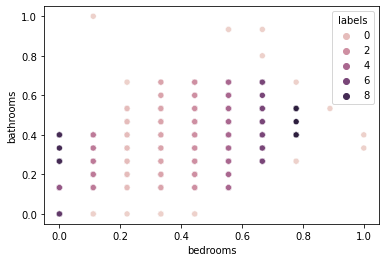

In [58]:
# Let's visualize the anomalies

sns.scatterplot(data = subset, x = 'bedrooms', y = 'bathrooms', hue = 'labels');

In [59]:
# Let's see the rows that were labeled as anomalies.
subset[subset.labels == -1]

,bedrooms,bathrooms,labels
175,0.222222,0.666667,-1
5149,0.666667,0.800000,-1
12346,0.333333,0.000000,-1
13536,0.111111,0.000000,-1
15361,0.777778,0.666667,-1
15422,1.000000,0.333333,-1
16090,0.222222,0.000000,-1
18239,0.111111,0.000000,-1
19604,0.111111,0.000000,-1
22986,0.444444,0.000000,-1
